In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [4]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
import torch
import matplotlib.pyplot as plt

from orthogonal_dfa.l_star.examples.bernoulli_parity import BernoulliParityOracle
from orthogonal_dfa.l_star.structures import DecisionTreeLeafNode
from orthogonal_dfa.l_star.sampler import UniformSampler
from orthogonal_dfa.l_star.decision_tree_to_dfa import *
from orthogonal_dfa.utils.pdfa import batched_iterated_matrix_multiply

In [6]:
oracle = BernoulliParityOracle(0.7, 0, modulo=8)

In [7]:
# oracle.membership_query([0, 0, 1, 0, 1, 1, 1])

In [50]:
us = UniformSampler(20)

In [51]:
# us.sample(np.random.default_rng(2))

In [52]:
import scipy

In [53]:
# help(scipy.stats.chisquare)

In [54]:
# chi_squared_p(np.arange(1000) % 62 == 0, np.arange(1000) % 64 == 0)

In [55]:
s = 0
a = 1
v = []

In [74]:
pt = {}
dt = DecisionTreeLeafNode(0)
# dt = dt.add_state(0, lambda x, o: o.membership_query(x + []))
# dt = dt.add_state(0, lambda x, o: o.membership_query(x + [1]))
# dt = dt.add_state(0, lambda x, o: o.membership_query(x + [1, 1]))

In [75]:
p_req = 0.005

In [76]:
min_samples_per_state = 3000
while True:
    result = compute_strings_by_state(
        alphabet_size=2,
        dt=dt,
        oracle=oracle,
        sampler=us,
        min_samples_per_state=min_samples_per_state,
        seed=0,
    )
    # if len(result) > 1:
    #     break
    for state in result:
        res = find_correlated_strings(
            result[state][:min_samples_per_state],
            oracle,
            us,
            p_req,
            100,
            1000,
            num_strings=30,
        )
        print(state, res is not None)
        if res is not None:
            break
    else:
        break
    print(state, [sum(v) for v in res], flush=True)
    dt = dt.split_state(state, dt.num_states, TriPredicate(res, 0.6))

correlation 0.10599024770500645
0.337
sampled 12 12


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.17it/s]

Attempting to find pair:   0%|          | 0/100 [00:14<?, ?it/s]

0 True
0 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 12, 12, 12, 12, 12, 12, 12, 12, 12]
correlation 0.07364628296839047
0.33433333
sampled 10 10


Finding more elements:   2%|1         | 18/1000 [00:01<00:55, 17.68it/s]

Attempting to find pair:   0%|          | 0/100 [00:20<?, ?it/s]

0 True
0 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
correlation 0.10158754439211616
0.399
sampled 13 13


Finding more elements:   2%|2         | 21/1000 [00:01<00:47, 20.61it/s]

Attempting to find pair:   0%|          | 0/100 [00:15<?, ?it/s]

0 True
0 [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 5, 13, 13, 13, 5, 13, 5, 13, 13, 13, 13, 13, 13, 13, 5]
correlation 0.08167078549753895
0.34966666
sampled 9 9


Finding more elements:   2%|2         | 21/1000 [00:01<00:47, 20.44it/s]

Attempting to find pair:   0%|          | 0/100 [00:12<?, ?it/s]

0 True
0 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
correlation 0.12366534774565996
0.42366666
sampled 14 14


Finding more elements:   2%|2         | 21/1000 [00:01<00:47, 20.67it/s]

Attempting to find pair:   0%|          | 0/100 [00:24<?, ?it/s]

0 True
0 [14, 14, 14, 14, 14, 14, 6, 14, 6, 6, 14, 6, 6, 6, 6, 6, 14, 6, 6, 14, 6, 6, 6, 14, 6, 6, 6, 14, 14, 14]


Attempting to find pair:  21%|##1       | 21/100 [00:01<00:03, 20.25it/s]

correlation 0.1443137529757536
0.42866668
sampled 8 8


Finding more elements:   2%|2         | 21/1000 [00:01<00:46, 20.86it/s]

0 True
0 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.74it/s]

correlation 0.16874808738063624
0.45266667
sampled 11 11


Finding more elements:   2%|2         | 21/1000 [00:01<00:47, 20.63it/s]

0 True
0 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.90it/s]

0 False


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.79it/s]

correlation 0.06742030534089717
0.27633333
sampled 13 8


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.23it/s]

correlation 0.08162329441364258
0.28766668
sampled 11 10


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.07it/s]

1 False


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.34it/s]

2 False


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.28it/s]

correlation 0.06818283134788787
0.305
sampled 14 9


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.25it/s]

3 False


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.86it/s]

correlation 0.06799170942448703
0.30033332
sampled 13 10


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.39it/s]

correlation 0.06563088086467844
0.28933334
sampled 9 10


Finding more elements:   2%|2         | 20/1000 [00:01<00:49, 19.96it/s]

correlation 0.06773494896779536
0.73
sampled 13 9


Finding more elements:   2%|2         | 21/1000 [00:01<00:48, 20.37it/s]

4 False


Attempting to find pair:  19%|#9        | 19/100 [00:01<00:04, 17.13it/s]

correlation 0.06930845956676689
0.29833335
sampled 9 7


Finding more elements:   2%|2         | 21/1000 [00:01<00:47, 20.69it/s]

5 False


Attempting to find pair:  20%|##        | 20/100 [00:01<00:04, 19.10it/s]

correlation 0.07084415914520747
0.27233332
sampled 10 13


Finding more elements:   2%|2         | 20/1000 [00:01<00:49, 19.92it/s]

correlation 0.0712763534338164
0.274
sampled 12 13


Finding more elements:   2%|1         | 19/1000 [00:01<00:52, 18.73it/s]

correlation 0.08807207151628246
0.29766667
sampled 14 11


Finding more elements:   2%|1         | 19/1000 [00:01<00:52, 18.54it/s]

6 False


Attempting to find pair:  19%|#9        | 19/100 [00:01<00:04, 18.23it/s]

correlation 0.06999755179757236
0.296
sampled 13 4


Finding more elements:   2%|2         | 20/1000 [00:01<00:50, 19.55it/s]

correlation 0.06659774925420253
0.274
sampled 12 9


Finding more elements:   2%|2         | 20/1000 [00:01<00:49, 19.69it/s]

correlation 0.0661901444703835
0.7313333
sampled 10 11


Finding more elements:   2%|2         | 20/1000 [00:01<00:50, 19.32it/s]

7 False


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0704e+04]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

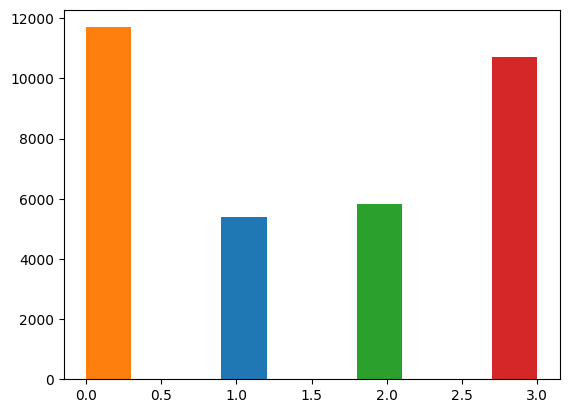

In [81]:
plt.hist(np.array(result[0]).sum(1) % 4)
plt.hist(np.array(result[1]).sum(1) % 4)
plt.hist(np.array(result[2]).sum(1) % 4)
plt.hist(np.array(result[3]).sum(1) % 4)

[[[1.         0.72661871 0.72661871 0.72661871 0.72661871 0.72661871
   0.72661871 0.72661871]
  [0.64748201 0.64748201 0.64748201 0.64748201 0.64748201 1.
   0.64748201 0.64748201]]

 [[0.16139241 0.99683544 0.16139241 0.16139241 0.16139241 0.16139241
   0.16455696 0.16139241]
  [0.68670886 0.68670886 0.68670886 0.68670886 0.68670886 0.68670886
   0.68670886 1.        ]]

 [[0.31446541 0.31446541 1.         0.31446541 0.31446541 0.31446541
   0.31446541 0.31446541]
  [0.47798742 0.47798742 0.47798742 0.47798742 1.         0.47798742
   0.47798742 0.47798742]]

 [[0.41077441 0.41077441 0.41077441 1.         0.41077441 0.41077441
   0.41077441 0.41077441]
  [0.15488215 1.         0.15488215 0.15488215 0.15488215 0.15488215
   0.15488215 0.15488215]]

 [[0.47260274 0.47260274 0.47260274 0.47260274 1.         0.47260274
   0.47260274 0.47260274]
  [0.62328767 0.62328767 0.62328767 0.62328767 0.62328767 0.62328767
   1.         0.62328767]]

 [[0.54271357 0.54271357 0.54271357 0.54271357 0

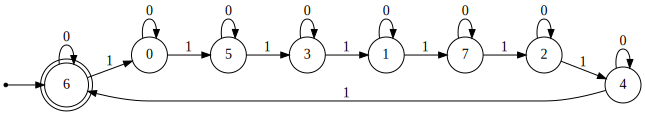

In [79]:
decision_tree_to_dfa(
    alphabet_size=2,
    dt=dt,
    oracle=oracle,
    sampler=us,
    min_samples_per_state=100,
    seed=0,
)

In [ ]:
t

In [ ]:
# f

In [ ]:
tk_tkt_sum = 0
for final_state in xs:
    tk_each = batched_iterated_matrix_multiply(
        torch.tensor(t[:, xs[final_state], :].transpose(1, 2, 0, 3))
    )
    tk_tkt_sum += torch.bmm(tk_each, tk_each.permute(0, 2, 1)).sum(0).numpy()
# Effectively, we have T_k and s_k, and we want to find pi minimizing sum_k |T_k^T pi - s_k|^2
# T_k^T because transition matrices have to be transposed since states are row vectors
# Finding the gradient, we have
# partial/partial pi_i J(pi)
# = partial/partial pi_i sum_k |T_k^T pi - s_k|^2
# = sum_k partial/partial pi_i |T_k^T pi - s_k|^2
# = sum_k 2 (T_k^T pi - s_k)^T partial/partial pi_i (T_k^T pi - s_k)
# = sum_k 2 (T_k^T pi - s_k)^T (T_k^T e_i)
# grad J(pi)/2
# = sum_k T_k (T_k^T pi - s_k)
# = sum_k T_k T_k^T pi - T_k s_k
# Setting this to 0, we get
# pi = (sum_k T_k T_k^T)^{-1}(sum_k T_k s_k)

In [ ]:
import numpy as np

In [ ]:
tk_each[3]

In [ ]:
t

In [ ]:
tk_each[0]

In [ ]:
dfa